In [1]:
## GET IMPORTS ##

import pandas as pd
import yfinance as yf
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
pd.set_option('expand_frame_repr', False)
import cufflinks as cf

In [34]:
df = yf.download('^ndx', period="1d", interval='1m') #Nasdaq
#df_sister_1 = yf.download('^GSPC', period="1d", interval='1m') # Dow Jones

df_sister_1 = yf.download('MSTR', period="1d", interval='1m') # Microstrategy

#Calculate correlation between Closeprices in both dfs
correlation = df['Adj Close'].corr(df_sister_1['Adj Close'])
print('Pearson correlation:', correlation)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Pearson correlation: 0.8225306746232522


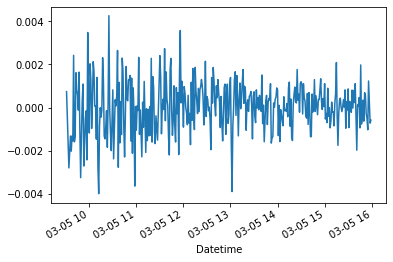

In [36]:
daily_changes = df['Adj Close'].pct_change(periods=1)
daily_changes.plot()

In [23]:
#Calculate RSI in both dataframes and add 5ignal based on rsi threshold ##
df['RSI'] = ta.RSI(df['Close'], timeperiod=14)
df_sister_1['RSI'] = ta.RSI(df_sister_1['Close'], timeperiod=14)

#CREATE SIGNALS FROM RSI in both dataframes ##
def signal_cat(df) :
    current_RSI=df['RSI']
    if current_RSI <= 20:
        return 2
    elif current_RSI <= 30 and current_RSI >= 20:
        return 1
    elif current_RSI >= 70 and current_RSI <= 75:
        return -1
    elif current_RSI >= 75:
        return -2
    else:
        return 0

df['signal_rsi']=df[['RSI']].apply(signal_cat, axis=1)
df_sister_1['signal_rsi']=df_sister_1[['RSI']].apply(signal_cat, axis=1)

#Include signal from sister dataframe into main df. 
df['signal_df_sister_1_rsi'] = df_sister_1['signal_rsi']

In [24]:
#Create a signal from where both rsi conditions are TRUE in main df. 

def signal_cat2(df) :
    main_rsi=df['signal_rsi']
    sister_rsi=df['signal_df_sister_1_rsi']
    if main_rsi == 2 and sister_rsi == 2:
        return 2
    elif main_rsi == -2 and sister_rsi == -2:
        return -2
    else:
        return 0

df['combined_signal_rsi']=df[['signal_rsi', 'signal_df_sister_1_rsi']].apply(signal_cat2, axis=1)


In [25]:
#CREATE Shifted Trend RSI indicator on main df rsi ##
#This function says that if current rsi > previous rsi 5 periods ago, then the bottom has happened and rsi is rising. 
#this smoothes out outliers so that false signals are not created (or dampened because of the weight you put on this function result)

def signal_cat3(df) :
    current_RSI=df['RSI']
    prev_RSI=df['prev_RSI']
    if prev_RSI < 35 and current_RSI >= 35:
        return 1
    elif prev_RSI >= 70 and current_RSI <= 70:
        return -1
    else:
        return 0

df['prev_RSI'] = df['RSI'].shift(1)
df['signal_shifted_trend_rsi']=df[['prev_RSI', 'RSI']].apply(signal_cat3, axis=1)

df;

In [26]:
# add sister adj close to main df

df['sister_adj_close'] = df_sister_1['Adj Close']

In [27]:
df3 = df[df['combined_signal_rsi'] < 0]
df3

,Open,High,Low,Close,Adj Close,Volume,RSI,signal_rsi,signal_df_sister_1_rsi,combined_signal_rsi,prev_RSI,signal_shifted_trend_rsi,sister_adj_close
Datetime,,,,,,,,,,,,,
2021-03-05 15:00:00-05:00,12671.678711,12686.898438,12671.678711,12686.636719,12686.636719,3033327,76.323853,-2,-2.0,-2,72.420498,0,631.849976


In [28]:
df4 = df[df['signal_shifted_trend_rsi'] <0]
df4

,Open,High,Low,Close,Adj Close,Volume,RSI,signal_rsi,signal_df_sister_1_rsi,combined_signal_rsi,prev_RSI,signal_shifted_trend_rsi,sister_adj_close
Datetime,,,,,,,,,,,,,
2021-03-05 12:26:00-05:00,12445.486328,12447.335938,12431.840820,12432.190430,12432.190430,2306302,69.410291,0,0.0,0,74.393203,-1,604.489990
2021-03-05 12:34:00-05:00,12462.961914,12465.434570,12455.284180,12455.284180,12455.284180,1939142,68.637526,0,0.0,0,72.971124,-1,603.570007
2021-03-05 12:41:00-05:00,12489.664062,12489.664062,12480.065430,12485.816406,12485.816406,2103249,69.115780,0,0.0,0,71.610976,-1,612.799988
2021-03-05 12:49:00-05:00,12526.811523,12528.834961,12516.645508,12517.586914,12517.586914,2083631,67.855109,0,0.0,0,72.751249,-1,607.799988
2021-03-05 13:20:00-05:00,12584.545898,12584.545898,12572.962891,12574.258789,12574.258789,2117007,65.856262,0,0.0,0,71.672810,-1,617.000000
2021-03-05 13:28:00-05:00,12603.917969,12603.917969,12584.298828,12584.298828,12584.298828,1415004,62.130860,0,0.0,0,71.989813,-1,616.364380
2021-03-05 13:41:00-05:00,12624.779297,12624.779297,12616.892578,12616.892578,12616.892578,1937291,65.156394,0,0.0,0,71.217502,-1,619.969971
2021-03-05 14:37:00-05:00,12641.319336,12644.589844,12633.198242,12633.288086,12633.288086,1594750,68.419160,0,0.0,0,72.301564,-1,611.809998
2021-03-05 14:39:00-05:00,12640.382812,12641.319336,12630.537109,12631.654297,12631.654297,2190234,64.706690,0,0.0,0,70.679031,-1,611.809998


In [29]:
cf.set_config_file(theme='pearl',sharing='public',offline=True)
df.iplot(kind="ohlc", keys=["Open", "High", "Low", "Close"],rangeslider=True)

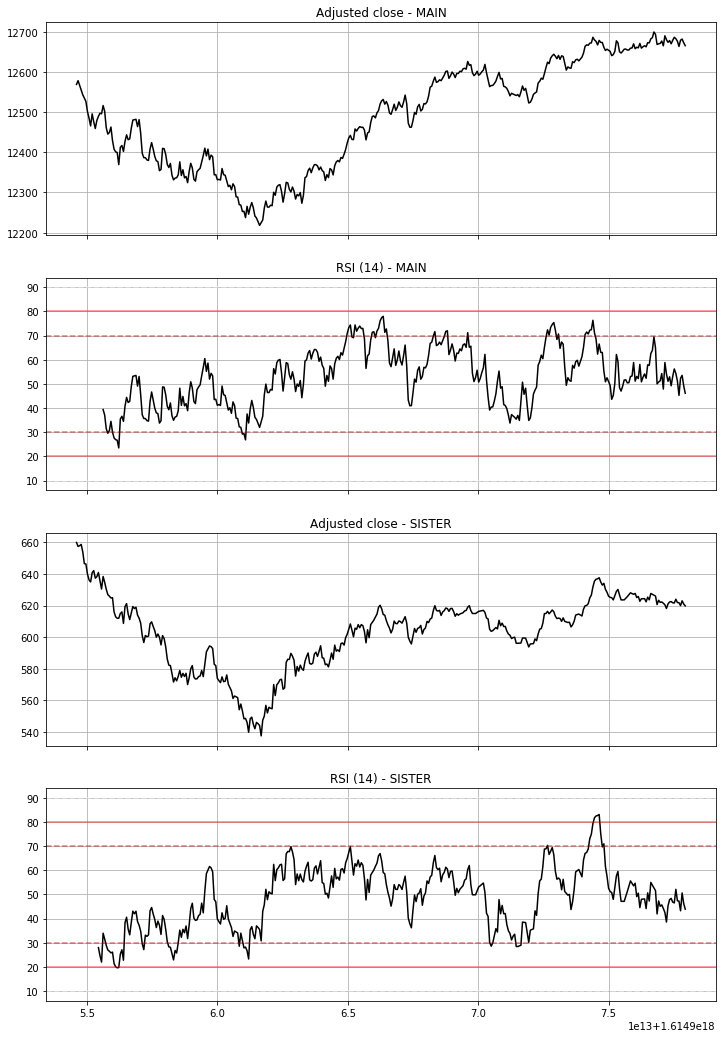

In [30]:
df = df.reset_index()
df_sister_1 = df_sister_1.reset_index()

df['Datetime'] = pd.to_numeric(pd.to_datetime(df['Datetime']))
df_sister_1['Datetime'] = pd.to_numeric(pd.to_datetime(df_sister_1['Datetime']))


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12,18), sharex=True)


line_color_1 = '#ff0000'
line_color_2 = '#bf0000'


ax1.title.set_text('Adjusted close - MAIN')
ax1.plot(df['Datetime'], df['Adj Close'], color='black')
ax1.grid()

ax2.title.set_text('RSI (14) - MAIN')
ax2.plot(df['Datetime'], df['RSI'], color='black')
ax2.axhline(10, linestyle='--', alpha=0.5, color='w')
ax2.axhline(20, linestyle='-', alpha=0.5, color=line_color_1)
ax2.axhline(30, linestyle='--', alpha=0.5, color=line_color_2)
ax2.axhline(70, linestyle='--', alpha=0.5, color=line_color_2)
ax2.axhline(80, linestyle='-', alpha=0.5, color=line_color_1)
ax2.axhline(90, linestyle='--', alpha=0.5, color='w')
ax2.grid()


ax3.title.set_text('Adjusted close - SISTER')
ax3.plot(df_sister_1['Datetime'], df_sister_1['Adj Close'], color='black')
ax3.grid()

ax4.title.set_text('RSI (14) - SISTER')
ax4.plot(df_sister_1['Datetime'], df_sister_1['RSI'], color='black')
ax4.axhline(10, linestyle='--', alpha=0.5, color='w')
ax4.axhline(20, linestyle='-', alpha=0.5, color=line_color_1)
ax4.axhline(30, linestyle='--', alpha=0.5, color=line_color_2)
ax4.axhline(70, linestyle='--', alpha=0.5, color=line_color_2)
ax4.axhline(80, linestyle='-', alpha=0.5, color=line_color_1)
ax4.axhline(90, linestyle='--', alpha=0.5, color='w')
ax4.grid()

In [31]:
#df4 = df.loc[df['signal_rsi']>=-2,'signal_df_sister_1_rsi'] >= -2
#df3 = df[df['signal_df_sister_1_rsi'] < 0]
#df3
#df2 = df[df['signal_rsi'] < 0]

#df_sister_1_2 = df[df['signal_rsi'] < 0]
#df_sister_1_3 = df[df['signal_rsi'] > 0]
#df_sister_1['Close'].min()


#sjekk det enorme volumet mot slutten å sisterplot!
#df_sister_1.plot()
#df4


#df5 = df['signal_rsi'].eq(-2) & df['signal_df_sister_1_rsi'].eq(-2)
#df6 = df5[df5] == True


In [ ]:
main_tresh = 0

if signal == 1:

calculate df for change in correlation

signal * corelation
    

In [32]:
df.corr(method ='pearson')

#muligens bruke denne for å se hvor verdiful en vekt er? Vil ikke svaret 0.5 si at det stemmer 50% av tiden? Feks når signal_rsi korrelerer 0.5 med rsi?

#feks - prev_rsi korrelerer 0.93 med prev rsi. Dvs at det er 93% sannsynlighet for at rsi er samme som forrige rsi. Må man kanskje se på 

,Datetime,Open,High,Low,Close,Adj Close,Volume,RSI,signal_rsi,signal_df_sister_1_rsi,combined_signal_rsi,prev_RSI,signal_shifted_trend_rsi,sister_adj_close
Datetime,1.000000,0.798377,0.795924,0.806388,0.803178,0.803178,-0.079372,0.413303,-0.183339,-0.355781,-0.060880,0.417812,-0.119271,0.387280
Open,0.798377,1.000000,0.998370,0.998005,0.994906,0.994906,-0.106434,0.390390,-0.195903,-0.270176,-0.069860,0.424211,-0.169095,0.821386
High,0.795924,0.998370,1.000000,0.998326,0.998024,0.998024,-0.107038,0.400806,-0.201423,-0.273908,-0.073765,0.418826,-0.154165,0.825525
Low,0.806388,0.998005,0.998326,1.000000,0.998382,0.998382,-0.103827,0.409303,-0.207701,-0.280704,-0.071797,0.426184,-0.159631,0.819137
Close,0.803178,0.994906,0.998024,0.998382,1.000000,1.000000,-0.103487,0.421432,-0.213983,-0.282823,-0.075289,0.423079,-0.145378,0.822531
Adj Close,0.803178,0.994906,0.998024,0.998382,1.000000,1.000000,-0.103487,0.421432,-0.213983,-0.282823,-0.075289,0.423079,-0.145378,0.822531
Volume,-0.079372,-0.106434,-0.107038,-0.103827,-0.103487,-0.103487,1.000000,-0.075723,0.022213,0.001441,0.001436,-0.108372,0.003227,-0.104736
RSI,0.413303,0.390390,0.400806,0.409303,0.421432,0.421432,-0.075723,1.000000,-0.602119,-0.483308,-0.101582,0.932415,-0.275263,0.407204
signal_rsi,-0.183339,-0.195903,-0.201423,-0.207701,-0.213983,-0.213983,0.022213,-0.602119,1.000000,0.325803,0.255737,-0.565424,0.002502,-0.192178
signal_df_sister_1_rsi,-0.355781,-0.270176,-0.273908,-0.280704,-0.282823,-0.282823,0.001441,-0.483308,0.325803,1.000000,0.252916,-0.489256,0.159764,-0.183451


In [33]:
pearson_correlation = df['Adj Close'].corr(df['sister_adj_close'])
pearson_correlation

0.8225306746232522

In [ ]:
Pearson. 

+1 - Complete positive correlation
+0.8 - Strong positive correlation
+0.6 - Moderate positive correlation
0 - no correlation whatsoever
-0.6 - Moderate negative correlation
-0.8 - Strong negative correlation
-1 - Complete negative correlation


#kanskje også ha med correlation mellom high, low og close også for å få med seg alt. blir mye daaaata.